<a href="https://colab.research.google.com/github/SabriMendoza/7506R-1C2023-GRUPO33/blob/main/7506R_TP1_GRUPO33_CHP3_ENTREGA_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo practico 1: Reserva de Hotel

**Trabajo Práctico 1 : Reservas de Hotel**

# Grupo 33
#Integrantes:
1.   Mendoza Hernandez, Sabrina Scarlet (108524)
2.   Valeriani, Matias Gabriel (108570)
3.   Jang, Lucas (109151)


#Importar librerias

In [1]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Guardar y cargar el modelo
import pickle
from urllib.request import urlretrieve

#Modelado
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report , f1_score, precision_score, make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import make_classification
from collections import defaultdict
import plotly.graph_objects as go
from sklearn.neural_network import MLPClassifier

#Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

* Funcion para mostrar la matriz de confusión con sus respectivas metricas

In [2]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='YlOrRd',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

#Matriz de confusión y metricas a considerar

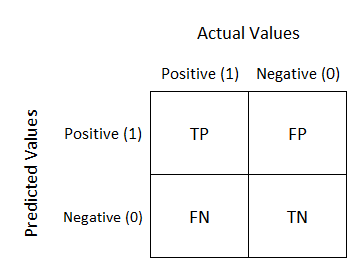

TP: True Positive (verdaderos positivos)

FP: False Positive (falsos positivos)

FN: False Negative (falsos negativos)

TN: True Negative (verdaderos negativos)



Las métricas que consideraremos, se calculan a partir de los datos brindados en la matriz de confusion. Con esta matriz se puede obtener precision, recall, f1 score y accuracy. 

* La precisión (**precision**) mide la proporción de verdaderos positivos (TP) entre los casos positivos pronosticados (TP + FP). Mide la capacidad del modelo para predecir correctamente los casos positivos.

  $Precision = \frac{TP}{TP + FP}$

* El recall (**recall**) mide la proporción de verdaderos positivos (TP) entre todos los casos positivos reales (TP + FN). Mide la capacidad del modelo para encontrar todos los casos positivos.

  $Recall = \frac{TP}{TP + FN}$

* El F1 score (**f1 score**) es la media armónica entre la precisión y el recall. Resume el rendimiento del modelo en términos de clasificación.

  $F1 Score = 2\frac{Precision.Recall}{Precision + Recall}$

* La exactitud (**accuracy**) mide la proporción de casos totales que se clasifican correctamente (TP + TN) sobre el total de casos (TP + TN + FP + FN). Mide la capacidad del modelo para clasificar correctamente todos los casos, tanto positivos como negativos.

  $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

# Preparacion de los dataframes

## Dataframe train

In [3]:
reservas = pd.read_csv("https://drive.google.com/uc?export=download&id=1fvs0y1EqWpmx_ZuhlSEzFjwCI0HZGCxv")
hotels = reservas.copy()
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60679 entries, 0 to 60678
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       60679 non-null  int64  
 1   arrival_date_year               60679 non-null  int64  
 2   arrival_date_week_number        60679 non-null  int64  
 3   adults                          60679 non-null  int64  
 4   children                        60679 non-null  int64  
 5   is_repeated_guest               60679 non-null  int64  
 6   previous_cancellations          60679 non-null  int64  
 7   previous_bookings_not_canceled  60679 non-null  int64  
 8   booking_changes                 60679 non-null  int64  
 9   agent                           60679 non-null  float64
 10  days_in_waiting_list            60679 non-null  int64  
 11  adr                             60679 non-null  float64
 12  required_car_parking_spaces     

* Dividimos las variables por un lado, y el target *is_canceled* por el otro, haciendo dataframes para cada caso. Posteriormente separamos en *x_train, x_test, y_train, y_test*

In [4]:
hotels_train = hotels.copy()
#hotels_train.drop('id', axis='columns', inplace=True)

target = 'is_canceled'
features = hotels.columns.tolist()
features.remove(target)

#Features
features_para_clasificar = hotels_train.columns.tolist()
features_para_clasificar.remove(target)
df_train_completo_x = hotels_train[features_para_clasificar]

#Target
df_train_completo_y = hotels_train[target].copy()

x_train, x_test, y_train, y_test = train_test_split(df_train_completo_x, 
                                                    df_train_completo_y, 
                                                    test_size=0.20, #20% al conjunto de test
                                                    random_state=0)

## Dataframe test

* Cargamos el dataset de test para guardarnos el id, luego cargaremos el que ya esta procesado con los features requeridos

El siguiente nos servirá unicamente para guardarnos el *id*

In [5]:
reservas_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1-5FFQZp2NmEqpBDGCD17e0QM0_AF7Ht2")
hotels_test = reservas_test.copy()

*hotels_test_* nos servirá para testear nuestro modelo y generar las predicciones que subiremos a Kaggle.

In [6]:
test = pd.read_csv("https://drive.google.com/uc?export=download&id=1OVHmmfGCqK_U1i404zGn5vVQPqh7aHuN")
hotels_test_ = test.copy()
hotels_test_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       26535 non-null  int64  
 1   arrival_date_year               26535 non-null  int64  
 2   arrival_date_week_number        26535 non-null  int64  
 3   adults                          26535 non-null  int64  
 4   children                        26535 non-null  int64  
 5   is_repeated_guest               26535 non-null  int64  
 6   previous_cancellations          26535 non-null  int64  
 7   previous_bookings_not_canceled  26535 non-null  int64  
 8   booking_changes                 26535 non-null  int64  
 9   agent                           26535 non-null  float64
 10  days_in_waiting_list            26535 non-null  int64  
 11  adr                             26535 non-null  float64
 12  required_car_parking_spaces     

#Clasificador KNN

* El algoritmo K-Nearest Neighbors (KNN) es un método de clasificación y regresión supervisada que se utiliza para predecir la etiqueta de un punto de datos basado en las etiquetas de los puntos de datos cercanos. La "K" en KNN representa el número de puntos de datos más cercanos que se utilizan para tomar la decisión de clasificación. KNN es un algoritmo basado en instancia, lo que significa que no hay una fase de entrenamiento explícita, sino que simplemente se almacenan los datos de entrenamiento para utilizarlos durante la fase de predicción.

Buscaremos los mejores hiperparámetros por medio de Randomized Search Cross Validation, posteriormente haremos un clasificador con dichos hiperparámetros mostrando sus respectivas métricas.

In [7]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(4,15), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search con 8 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=8, scoring=scorer_fn, n_iter=10, random_state=5)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.70944254, 0.73197142, 0.7192759 , 0.7675754 , 0.7114679 ,
       0.76806853, 0.75941515, 0.76683391, 0.79030682, 0.72137629])

In [8]:
print("Mejores hiperparametros: ")
print(rand.best_params_)

print("\nMejor metrica: ")
print(rand.best_score_)

Mejores hiperparametros: 
{'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan', 'algorithm': 'ball_tree'}

Mejor metrica: 
0.7903068169985223


              precision    recall  f1-score   support

           0       0.80      0.76      0.78      5966
           1       0.78      0.82      0.80      6170

    accuracy                           0.79     12136
   macro avg       0.79      0.79      0.79     12136
weighted avg       0.79      0.79      0.79     12136

Accuracy: 0.7888101516150297
Precision: 0.7794824112815745
Recall: 0.8152350081037277
f1 score: 0.7969579339301276


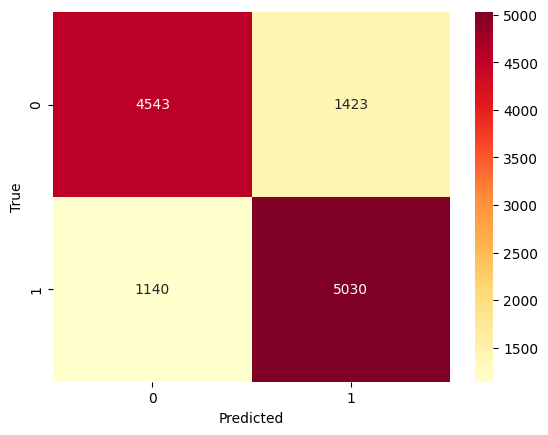

In [9]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

metricas(y_pred,y_test)
accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))


##Guardamos el modelo

Ahora guardamos el mejor modelo en base a nuestra conveniencia. Luego de varios intentos de modelos, conseguimos el mejor clasificador KNN que será evaluado posteriormente.

In [10]:
#filename = "f1score_0-7904_n_neighbors-7_metric-manhattan_algorithm-kd_tree.pickle"

#pickle.dump(best_knn, open(filename, "wb"))

#loaded_model = pickle.load(open(filename, "rb"))

##Mejor clasificador KNN

* Cargamos el clasificador desde githubm previamente encontrado con Randomized Search Cross Validation

n_neighbors: 7
metric: manhattan
algorithm: kd_tree
weights: distance
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      5966
           1       0.78      0.81      0.80      6170

    accuracy                           0.79     12136
   macro avg       0.79      0.79      0.79     12136
weighted avg       0.79      0.79      0.79     12136

Accuracy: 0.7885629531970996
Precision: 0.7793798449612404
Recall: 0.8147487844408428
f1 score: 0.7966719492868464


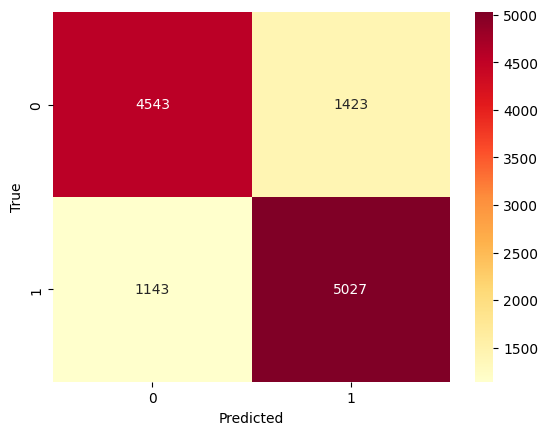

In [11]:
url = 'https://github.com/SabriMendoza/7506R-1C2023-GRUPO33/raw/main/f1score_0-7904_n_neighbors-7_metric-manhattan_algorithm-kd_tree.pickle'

urlretrieve(url, 'f1score_0-7904_n_neighbors-7_metric-manhattan_algorithm-kd_tree.pickle')

filename = "f1score_0-7904_n_neighbors-7_metric-manhattan_algorithm-kd_tree.pickle"

# load model
model = pickle.load(open(filename, "rb"))

model_params = model.get_params()
print(f"n_neighbors: {model_params['n_neighbors']}")
print(f"metric: {model_params['metric']}")
print(f"algorithm: {model_params['algorithm']}")
print(f"weights: {model_params['weights']}")

#Predicción con mejor estimador
y_pred=model.predict(x_test)

metricas(y_pred,y_test)

accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

* Predicciones en el dataframe test.

In [12]:
y_pred = model.predict(hotels_test_)

df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('submission_best_knn.csv',index=False)

#Clasificador SVM


Las máquinas de vectores de soporte (SVM) son un método de aprendizaje supervisado utilizado para clasificar datos en dos o más categorías. El objetivo de SVM es encontrar el hiperplano que mejor separa los datos de diferentes categorías. SVM se basa en la idea de encontrar el margen máximo que separa las clases en el espacio de características. El margen se define como la distancia entre el hiperplano de separación y el punto más cercano de cada clase. SVM también puede utilizar un kernel para mapear los datos a un espacio de características de mayor dimensión para separar las clases de manera más efectiva.

##Normalización de Datos

Normalizamos los datos para garantizar que todas las características o variables de entrada tengan la misma escala.

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      5966
           1       0.81      0.82      0.81      6170

    accuracy                           0.81     12136
   macro avg       0.81      0.81      0.81     12136
weighted avg       0.81      0.81      0.81     12136

Accuracy: 0.8099044166117337
Precision: 0.8092874299439552
Recall: 0.8191247974068071
f1 score: 0.8141763995167137


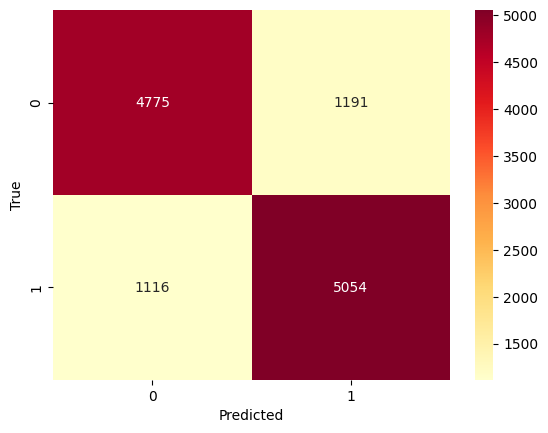

In [14]:
#Construyo un modelo SVM  
svm_minmax= SVC(cache_size=2000)

#Lo entreno con los datos escalados con min max
svm_minmax.fit(x_train_minmax, y_train)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(x_test_minmax)
metricas(y_pred_minmax,y_test)

accuracy=accuracy_score(y_test,y_pred_minmax)
precision=precision_score(y_test,y_pred_minmax)
recall=recall_score(y_test,y_pred_minmax)
f1=f1_score(y_test,y_pred_minmax)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

## SVM - Kernels

La idea detrás del parámetro Kernel es encontrar un hiperplano que pueda separar las clases de manera más efectiva en el espacio de características de mayor dimensión.

* SVM con kernel polinómico

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      5966
           1       0.85      0.83      0.84      6170

    accuracy                           0.84     12136
   macro avg       0.84      0.84      0.84     12136
weighted avg       0.84      0.84      0.84     12136

Accuracy: 0.8366842452208306
Precision: 0.8457727873183619
Recall: 0.8301458670988655
f1 score: 0.8378864714542777


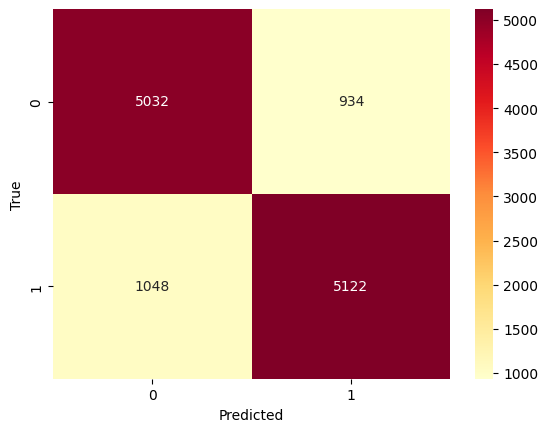

In [15]:
#Creo un clasificador con kernel polinomico y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='poly', C=5, gamma=1,cache_size=2000)
clf.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_pol=clf.predict(x_test_minmax)
metricas(y_pred_pol,y_test)

accuracy=accuracy_score(y_test,y_pred_pol)
precision=precision_score(y_test,y_pred_pol)
recall=recall_score(y_test,y_pred_pol)
f1=f1_score(y_test,y_pred_pol)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Observamos que mediante el kernel polinómico se obtienen mejores métricas que las vistas en SVM sin kernel.

* Predicciones en el dataframe test.

In [16]:
y_pred = clf.predict(hotels_test_)

df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('submission_svm_kernel_polinomico.csv',index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


#Clasificador Random Forest

Este algoritmo combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste del modelo. Cada árbol de decisión en Random Forest se entrena en una muestra aleatoria de los datos de entrenamiento y selecciona un subconjunto aleatorio de características para hacer la división en cada nodo del árbol. Luego, las predicciones de cada árbol se combinan para obtener una predicción final para una nueva instancia.

* Utilizamos Randomized Search Cross Validation para obtener los mejores hiperparametros. Posteriormente mostramos el mejor clasificador obtenido luego de experimentar diferentes combinaciones de parametros.

In [17]:
model = RandomForestClassifier()
param_grid = {
    'n_estimators': np.arange(30, 100, 4),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'criterion': ['gini', 'entropy']
}

scorer = make_scorer(f1_score)
# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(model, param_distributions=param_grid,scoring=scorer, n_iter=30, cv=5, n_jobs=-1)
random_search.fit(x_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

y_pred = random_search.predict(x_test)
f1=f1_score(y_test,y_pred)
print("f1 score: "+str(f1))

Mejores hiperparámetros encontrados: {'n_estimators': 94, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}
f1 score: 0.8772756827048114


##Mejor clasificador Random Forest

Creamos un clasificador Random Forest con los mejores hiperparámetros hallados con Cross Validation. Posteriormente mostramos la matriz de confusión con sus respectivas métricas.

In [18]:
rfc = RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=1,
                             min_samples_split=3,
                             n_estimators=80)
#Entrenamos el modelo
model = rfc.fit(X = x_train, y = y_train)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5966
           1       0.88      0.88      0.88      6170

    accuracy                           0.88     12136
   macro avg       0.88      0.88      0.88     12136
weighted avg       0.88      0.88      0.88     12136

Accuracy: 0.877636783124588
Precision: 0.8813283412013674
Recall: 0.8774716369529983
f1 score: 0.8793957605782505


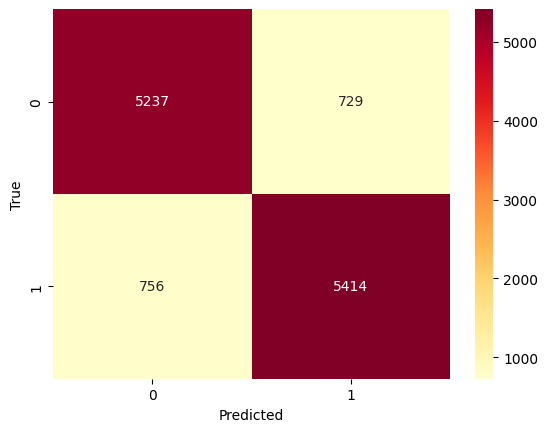

In [19]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)
metricas(y_pred,y_test)

accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

* Gráficamos uno de los arboles de decisión. Para este caso elegimos arbitrariamente el estimador 48, y mostramos el arbol con los primeros nodos.

In [20]:
model.estimators_[48]

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=3, random_state=546147920)

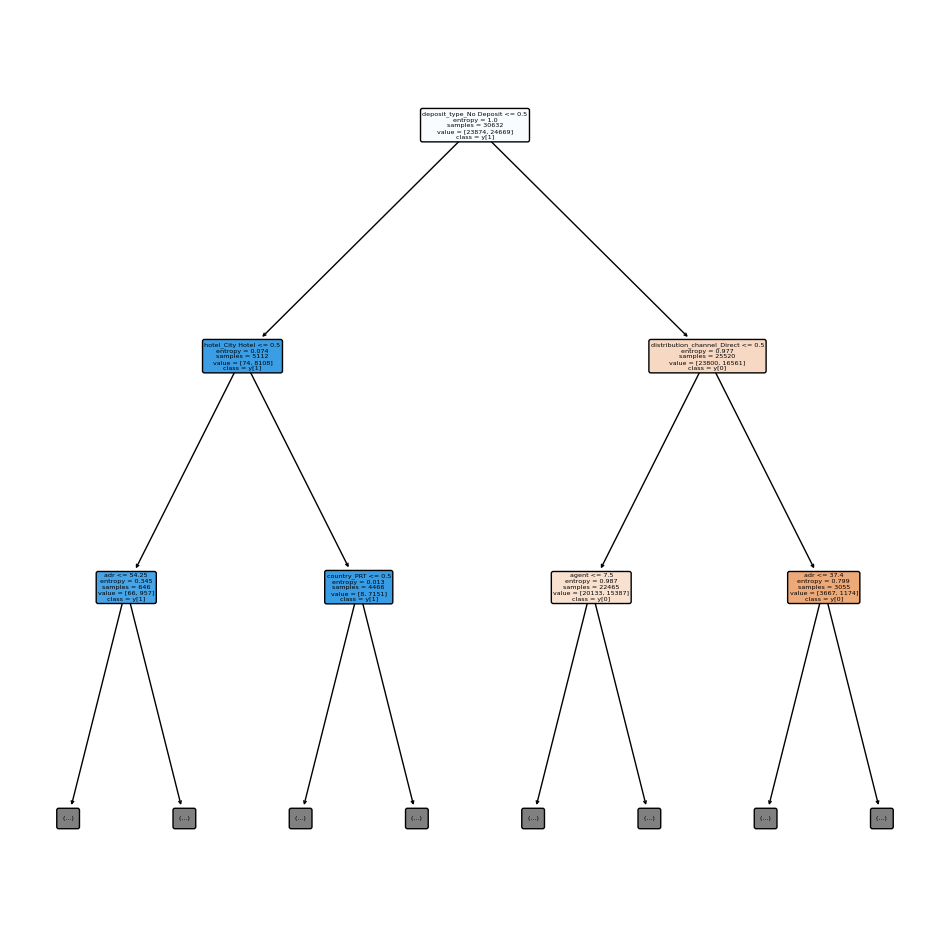

In [21]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model.estimators_[48],
                         max_depth=2,
                         feature_names=list(df_train_completo_x),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

* Predicciones en el dataframe test.

In [22]:
y_pred = model.predict(hotels_test_)

df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('submission_best_rf.csv',index=False)

#Clasificador XGBoost

Este algoritmo se basa en el concepto de boosting, que implica la combinación de varios modelos de aprendizaje débiles para crear un modelo final más preciso y robusto. La idea detrás de XGBoost es mejorar el algoritmo de Gradient Boosting, que se centra en la optimización de una función de pérdida mediante la creación de árboles de decisión.

* Creamos el clasificador con los mejores parametros encontrados manualmente probando combinaciones de ellos.

In [23]:
xgb_model = xgb.XGBClassifier(random_state=0, eta=0.5, n_estimators=100, max_depth=11, colsample_bytree=1, subsample=1, objective='reg:logistic')
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.5,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='reg:logistic', ...)

AUC: 0.9492001541963074
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5966
           1       0.87      0.88      0.87      6170

    accuracy                           0.87     12136
   macro avg       0.87      0.87      0.87     12136
weighted avg       0.87      0.87      0.87     12136

Accuracy: 0.8705504284772577
Precision: 0.8695163104611924
Recall: 0.8769854132901135
f1 score: 0.8732348906640846


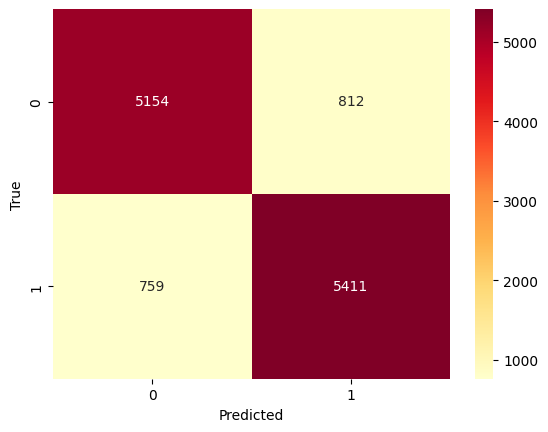

In [24]:
#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

metricas(y_pred,y_test)

accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

* Predicciones en el dataframe test.

In [25]:
y_pred = xgb_model.predict(hotels_test_)

df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('submission_xgboost.csv',index=False)

**XGBoost con Cross Validation**

In [26]:
#Datos de entrenamiento en formato DMatrix
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.5, 'max_depth': 11},num_boost_round=100,metrics='auc',seed=0, early_stopping_rounds=9)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.936587,0.000428,0.926383,0.002756
1,0.946018,0.001551,0.933151,0.003036
2,0.953643,0.000621,0.937506,0.002637
3,0.959126,0.001110,0.939624,0.002580
4,0.963096,0.001277,0.941140,0.001787
5,0.968479,0.001522,0.941799,0.001728
6,0.971661,0.001211,0.942001,0.001729
7,0.973564,0.001427,0.942195,0.001749
8,0.975556,0.001302,0.942313,0.002051


#Ensambles hibiridos Stacking y Voting

##Stacking

El stacking combina varios modelos de aprendizaje automático de nivel inferior en un modelo de nivel superior que utiliza las predicciones de los modelos de nivel inferior como entradas. El modelo de nivel superior se entrena para predecir el resultado final en función de las salidas de los modelos de nivel inferior.

In [27]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [28]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [29]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=1,
                             min_samples_split=3,
                             n_estimators=80),
               'xgb': xgb.XGBClassifier(random_state=0, eta=0.5, n_estimators=100, max_depth=11, colsample_bytree=1, subsample=1, objective='reg:logistic'),
               'log-reg': LogisticRegression(max_iter=5000)}


#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   43.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating xgb


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating log-reg


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.3min finished


In [30]:
#Modelos Base
base_models = [('random_forest', RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=1,
                             min_samples_split=3,
                             n_estimators=80)),
               ('xgb', xgb.XGBClassifier(random_state=0, eta=0.5, n_estimators=100, max_depth=11, colsample_bytree=1, subsample=1, objective='reg:logistic')),
               ('log-reg', LogisticRegression(max_iter=5000))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [31]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 31.3min finished


In [32]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prep

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5966
           1       0.88      0.88      0.88      6170

    accuracy                           0.87     12136
   macro avg       0.87      0.87      0.87     12136
weighted avg       0.87      0.87      0.87     12136

Accuracy: 0.8744232036914964
Precision: 0.8773554256010396
Recall: 0.8753646677471637
f1 score: 0.8763589161122829


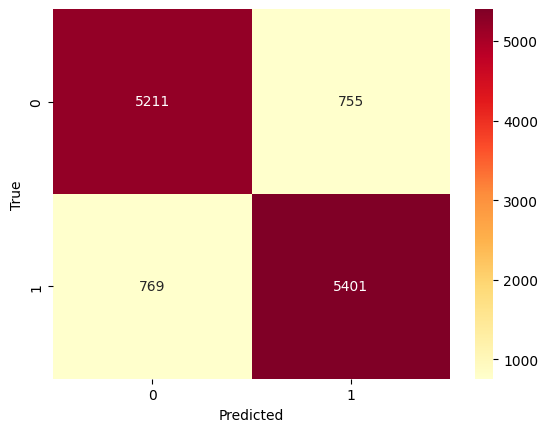

In [33]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)

metricas(y_pred_st,y_test)

accuracy=accuracy_score(y_test,y_pred_st)
precision=precision_score(y_test,y_pred_st)
recall=recall_score(y_test,y_pred_st)
f1=f1_score(y_test,y_pred_st)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

##Voting

El voting combina las predicciones de varios modelos de nivel inferior en una sola predicción. Se utilizan diferentes métodos de votación, como la votación suave o la votación dura. En la votación suave, se toma el promedio de las predicciones de probabilidad de los modelos de nivel inferior. En la votación dura, se toma la predicción más frecuente de los modelos de nivel inferior.

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5966
           1       0.88      0.87      0.88      6170

    accuracy                           0.88     12136
   macro avg       0.88      0.88      0.88     12136
weighted avg       0.88      0.88      0.88     12136

Accuracy: 0.876977587343441
Precision: 0.8829212379236941
Recall: 0.8739059967585089
f1 score: 0.8783904862751487


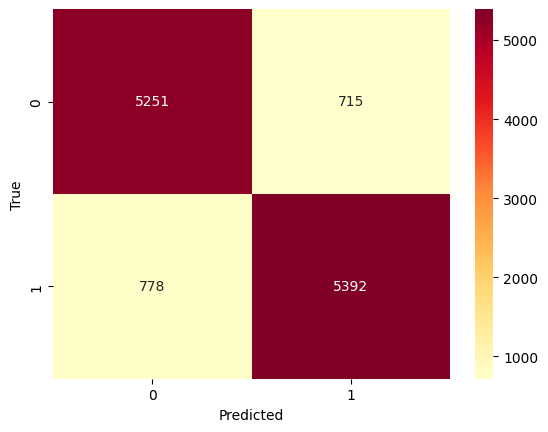

In [34]:
#Creo clasificadores

log_clf = LogisticRegression(max_iter=4000)
rnd_clf = RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=1,
                             min_samples_split=3,
                             n_estimators=80)
xgb_clf = xgb.XGBClassifier(random_state=0, eta=0.5, n_estimators=100, max_depth=11, colsample_bytree=1, subsample=1, objective='reg:logistic')

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('xgb',xgb_clf)], voting = 'hard')

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred = vot_clf.predict(x_test)
metricas(y_pred,y_test)

accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

##Submission stacking

Ya que obtuvimos métricas muy similares en stacking y voting, decidimos realizar las predicciones con un solo clasificador. Utilizaremos stacking.

* Predicciones en el dataframe test.

In [35]:
y_pred = stacking_model.predict(hotels_test_)
df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred})
df_submission.to_csv("submission_stacking.csv", index=False)